In [17]:
import numpy as np
%pylab
%matplotlib inline


import skimage.io as sk
from Functions import image_processing as ip
from Functions import region_merging as rm
from Functions import seeded_region_growing as srg
from Functions import seed_detection as sd

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
l = [1,5,3]
a = np.ndarray(len(l))
a[0:len(l)] = l
print(a)

[1. 5. 3.]


In [3]:
img = sk.imread("../Data/N2DH-GOWT1/img/t01.tif") #Bild laden
print (img.shape)

(1024, 1024)


In [4]:
img_n = ip.img_resize(img,400,400)
ip.show_image(img_n,15,8)

AttributeError: 'builtin_function_or_method' object has no attribute 'img_resize'

In [ ]:
t = np.zeros((5,5))

In [ ]:
from PIL import Image


test = np.zeros([100,100])
test[30:40,30:40] = 1
ip.show_image(test,15,8)

im = Image.fromarray(test)
im.save("unittest.tif")




In [2]:
image_regions = sk.imread("../Result_Pictures/Seeded_Region_Growing/N2DH-GOWT1/srg_t01.tif")
image_intensity = sk.imread("../Data/N2DH-GOWT1/img/t01.tif")  # load image
image_intensity = image_intensity[300:400, 300:500]
image_regions = rm.distance_merging_while(image_regions, 0.1, image_intensity)
ip.show_image(image_regions, 15, 8)

C:\Users\ijung\anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:2618: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
C:\Users\ijung\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ijung\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [49]:
def find_neigboring_regions(reg):
    """

    :param reg:
    :return:
    """
    max_region = max(reg.flatten())
    inter_region_neighbors = np.zeros((int(max_region), int(max_region)))
    for region_number in range(1, int(max_region)+1):
        neighboring_regions = find_neighbors_one_region(reg, region_number)
        inter_region_neighbors[int(region_number)-1, neighboring_regions - 1] = 1
    inter_region_neighbors = np.triu(inter_region_neighbors)  # upper triangle
    return inter_region_neighbors


def find_neighbors_one_region(reg, region_number):
    """

    :param reg:
    :param region_number:
    :return:
    """
    neighboring_regions = np.zeros((reg.shape[0] + 2, reg.shape[1] + 2))
    reg = ip.add_border(reg)
    reg = reg.astype(int)
    pos_pixel_region = np.where(reg == region_number)

    neighboring_regions[pos_pixel_region[0], pos_pixel_region[1] - 1] = reg[
        pos_pixel_region[0], pos_pixel_region[1] - 1]
    neighboring_regions[pos_pixel_region[0], pos_pixel_region[1] + 1] = reg[
        pos_pixel_region[0], pos_pixel_region[1] + 1]
    neighboring_regions[pos_pixel_region[0] - 1, pos_pixel_region[1]] = reg[
        pos_pixel_region[0] - 1, pos_pixel_region[1]]
    neighboring_regions[pos_pixel_region[0] + 1, pos_pixel_region[1]] = reg[
        pos_pixel_region[0] + 1, pos_pixel_region[1]]

    neighboring_regions[pos_pixel_region[0], pos_pixel_region[1]] = 0
    neighboring_regions_unique = np.unique(neighboring_regions.flatten())
    pos_zero = np.where(neighboring_regions_unique == 0)
    neighboring_regions_unique = np.delete(neighboring_regions_unique, pos_zero[0])
    #neighboring_regions_unique = neighboring_regions_unique.tolist()
    neighboring_regions_unique = neighboring_regions_unique.astype(int)
    return neighboring_regions_unique


def region_distance(img, reg):
    """
    calculates distance between all regions
    :param img: intensity values (2d array)
    :param reg: region numbers (2d array)
    :return: 2d array with distances between all regions, only in upper pyramid
    (region numbers are row and col number)
    inter_region_distances is upper triangle matrix with mean intensity distances between regions (2d array)
    mean values of all regions (list of floats)
    """

    max_region = int(max(reg.flatten()))
    max_intensity = np.amax(img)
    inter_region_distances = np.ones((int(max_region), int(max_region)))
    means = srg.mean_region(img, reg)
    inter_region_neighbors = find_neigboring_regions(reg)

    for row_number in range(0, int(max_region)):
        neighboring_regions = np.where(inter_region_neighbors[row_number, :] == 1)[0]
        for col_number in neighboring_regions:
            inter_region_distances[row_number][col_number] = distance_between_regions(row_number, col_number,
                                                                                      max_intensity, means)
    return inter_region_distances, means, inter_region_neighbors


def distance_between_regions(region1, region2, max_intensity, means):
    distance = abs(means[region1] - means[region2]) / max_intensity
    return distance


def one_merged_region_mean(img, reg, region_number):
    """
    calculates the mean of changed region
    :param img: intensity values (2d array)
    :param reg: region numbers (2d array)
    :param region_number: number of the changed region (int)
    :return: mean value of changed position (float)
    """
    pos_new_reg = np.where(reg == region_number)
    single_mean = np.mean(img[pos_new_reg[0], pos_new_reg[1]])
    return single_mean


def region_distance_new(img, reg, pos_min_dist, means, inter_region_distances, inter_region_neighbors):
    """
    updates array of distances of mean intensity values between all changed regions
    :param img: intensity values (2d array)
    :param reg: region numbers (2d array)
    :param pos_min_dist: region number of changed regions (tuple(x,y), pos_min_dist[0] is resulting region number,
                         pos_min_dist[1] is region_number to be removed)
    :param means: mean values of all regions (list of floats)
    :param inter_region_distances: distances between mean intensity values of regions (2d array)
    :param inter_region_neighbors:
    :return: inter_region_distances: updated distances between mean intensity values of regions
    """

    region_count = inter_region_distances.shape[0]
    maximal_intensity = np.amax(img)
    changed_region1 = int(pos_min_dist[0])  # Regions Nummer 1 die übernommen wird
    changed_region2 = int(pos_min_dist[1])
    means = update_mean_values(means, changed_region1, changed_region2, img, reg)
    inter_region_distances = update_distances(changed_region1, changed_region2, inter_region_distances, region_count,
                                              means, maximal_intensity, inter_region_neighbors)
    return inter_region_distances


def update_distances(changed_region1, changed_region2, inter_region_distances, region_count, means, maximal_intensity,
                     inter_region_neighbors):
    """
    updates distance values of changed regions, value 500 for removed regions
    :param changed_region1: resulting region number for merged region
    :param changed_region2: region number which is going to be removed
    :param inter_region_distances: distances between mean intensity values of regions (2d array)
    :param region_count: amount of different regions at beginning of merging process (int)
    :param means: mean intensity values of regions (list)
    :param maximal_intensity: maximal intensity value of image
    :param inter_region_neighbors:
    :return: updated inter_region distances (2d array)
    """
    neighboring_regions = np.where(inter_region_neighbors[changed_region1, :] != 0)[0]
    for col_number in neighboring_regions:
        if col_number > changed_region1:
            inter_region_distances[changed_region1][col_number] = distance_between_regions(changed_region1, col_number,
                                                                                           maximal_intensity, means)
    for row_number in neighboring_regions:
        if row_number < changed_region1:
            inter_region_distances[row_number][changed_region1] = distance_between_regions(changed_region1, row_number,
                                                                                           maximal_intensity, means)
    inter_region_distances[changed_region2][0:region_count] = 500
    inter_region_distances[0:region_count][changed_region2] = 500
    return inter_region_distances


def update_neighboring_regions(inter_region_neighbors, changed_region1, changed_region2):
    inter_region_neighbors[changed_region1, :] = inter_region_neighbors[changed_region1, :] + inter_region_neighbors[
                                                                                              changed_region2, :]
    return inter_region_neighbors


def update_mean_values(means, changed_region1, changed_region2, img, reg):
    """
    updates mean value for merged regions in list of mean values, value 500 for unused means
    :param means: mean intensity values of regions (list of ints)
    :param changed_region1: region number for merged region (int)
    :param changed_region2: region number to be removed (int)
    :param img: intensity values (2d array)
    :param reg: region numbers (2d array)
    :return:
    """
    means[changed_region2] = 500
    means[changed_region1] = one_merged_region_mean(img, reg, changed_region1 + 1)
    return means


def position_of_minimal_distance(dis, min_distance):
    minimal_distances = np.where(dis == min_distance)
    pos_min_dist = list(zip(minimal_distances[0], minimal_distances[1]))[0]
    pos_min_dist = (int(pos_min_dist[0]), int(pos_min_dist[1]))
    return pos_min_dist


def updates_region_numbers(inter_region_distances, reg, min_distance):
    """
    changes region number to region number of merged region
    :param inter_region_distances: distances between mean intensity values of regions (2d array)
    :param reg: region numbers (2d array)
    :param min_distance: minimal distance of mean intensity values between to regions

    :return: reg: updated region numbers (2d array)1
    :return: pos_min_dist: position of minimal distance in inter_region_distances array (tuple(x,y))
    """
    pos_min_dist = position_of_minimal_distance(inter_region_distances, min_distance)

    pixel_to_change = np.where(reg == pos_min_dist[
        1] + 1)  # column in inter_region_distances is region to be changed(column number bigger than row number)
    pixel_to_change_rows = pixel_to_change[0]
    pixel_to_change_cols = pixel_to_change[1]
    reg[pixel_to_change_rows, pixel_to_change_cols] = pos_min_dist[0] + 1
    return reg, pos_min_dist


def distance_merging_while(reg, threshold, img):
    """
    region merging algorithm by similarity of mean intensity values of regions
    :param reg: region numbers (2d array)
    :param threshold: distance intensity value below which regions are merged (float between 0 and 1)
    :param img: intensity value (2d array)
    :return: merged regions by intensity similarity (2d array)
    """

    result_region_distance = region_distance(img, reg)
    inter_region_distances = result_region_distance[0]
    means = result_region_distance[1]
    inter_region_neighbors = result_region_distance[2]

    min_distance = np.nanmin(inter_region_distances)
    while minimal_distance_is_similar(threshold, min_distance):
        updated_regions = updates_region_numbers(inter_region_distances, reg, min_distance)
        reg = updated_regions[0]
        pos_min_dist = updated_regions[1]

        inter_region_neighbors = update_neighboring_regions(inter_region_neighbors, pos_min_dist[0], pos_min_dist[1])
        inter_region_distances = region_distance_new(img, reg, pos_min_dist, means, inter_region_distances,
                                                     inter_region_neighbors)
        min_distance = np.nanmin(inter_region_distances)
    return reg, inter_region_neighbors, means


def minimal_distance_is_similar(threshold, min_distance):
    if min_distance < threshold:
        return True
    return False


def calculate_regions_size(regions):
    max_region = int(np.amax(regions))
    region_sizes = []
    for region_number in range(0, max_region):
        region_count = np.sum(regions == region_number)
        region_sizes.append(region_count)
    region_sizes = np.asarray(region_sizes)
    pos_empty_regions = np.where(region_sizes == 0)[0]
    region_sizes[pos_empty_regions] = 1000000
    return region_sizes


def find_smallest_region(region_sizes):
    smallest_size = np.amin(region_sizes)
    smallest_region = np.where(region_sizes == smallest_size)[0]
    smallest_region = int(smallest_region[0])
    return smallest_region


def find_most_similar_region(means, smallest_region, inter_region_neighbors, img):
    means = np.asarray(means)
    max_intensity = int(np.amax(img))
    distances = np.ones(means.shape)
    neighboring_regions = np.where(inter_region_neighbors[smallest_region, :] != 0)[0]
    distances[neighboring_regions] = abs(means[neighboring_regions] - means[smallest_region]) / max_intensity
    smallest_distance = np.amin(distances)
    closest_neighbor = np.where(distances == smallest_distance)[0]
    closest_neighbor = int(closest_neighbor[0])
    print(closest_neighbor)
    #closest_neighbor = closest_neighbor[0]
    return closest_neighbor  # number of region starts with 0


def update_regions(reg, closest_neighbor, smallest_region):  # merging
    pos_smallest_region = np.where(reg == int(smallest_region) + 1)
    reg[pos_smallest_region[0], pos_smallest_region[1]] = closest_neighbor + 1
    return reg


def update_region_sizes(region_sizes, smallest_region, closest_neighbor):
    region_sizes[closest_neighbor] = region_sizes[smallest_region] + region_sizes[closest_neighbor]
    region_sizes[smallest_region] = 1000000
    return region_sizes


def region_merging_size(img, reg, inter_region_neighbors, means, threshold):
    region_sizes = calculate_regions_size(reg)
    smallest_region = find_smallest_region(region_sizes)
    while region_sizes[smallest_region] < threshold:
        print(region_sizes[smallest_region])
        closest_neighbor = find_most_similar_region(means,smallest_region, inter_region_neighbors, img)
        reg = update_regions(reg, closest_neighbor, smallest_region)
        means = update_mean_values(means, closest_neighbor, smallest_region, img, reg)
        region_sizes = update_region_sizes(region_sizes, smallest_region, closest_neighbor)
        smallest_region = find_smallest_region(region_sizes)
        inter_region_neighbors = update_neighboring_regions(inter_region_neighbors, closest_neighbor, smallest_region)
    return reg



C:\Users\ijung\anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:2618: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
C:\Users\ijung\PycharmProjects\2021-topic-04-team-04\Functions\seed_detection.py:51: RuntimeWarning: overflow encountered in ubyte_scalars
  neighborhood_distance.append((img[p] - img[i, j]) / img[p])  # adds relative euclidean distance to list
C:\Users\ijung\PycharmProjects\2021-topic-04-team-04\Functions\seed_detection.py:51: RuntimeWarning: invalid value encountered in ubyte_scalars
  neighborhood_distance.append((img[p] - img[i, j]) / img[p])  # adds relative euclidean distance to list
C:\Users\ijung\PycharmProjects\2021-topic-04-team-04\Functions\seed_detection.py:51: RuntimeWarning: divide by zero encountered in ubyte_scalars
  neighborhood_distance.append((img[p] - img[i, j]) / img[p])  # adds relative euclidean distance to list


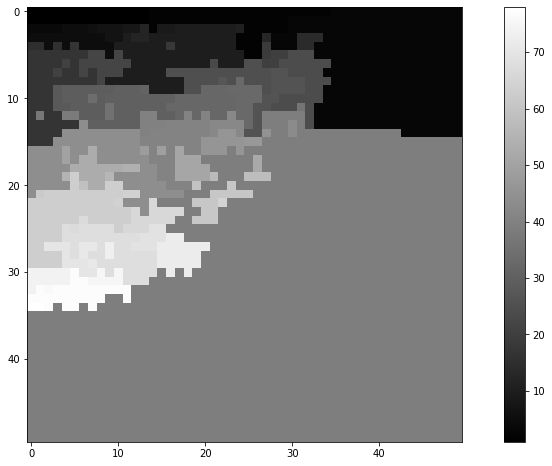

In [19]:
image_intensity = sk.imread("../Data/N2DH-GOWT1/img/t01.tif")  # load image
image_intensity = image_intensity[350:400, 400:450]
image_r = sd.seeds(image_intensity, 0.1, 1)
image_r = sd.seed_merging(image_r)
image_r = srg.region_growing(image_intensity, image_r)
ip.show_image(image_r,15,8)

[[1. 1. 1. ... 3. 3. 3.]
 [1. 1. 1. ... 3. 3. 3.]
 [4. 4. 4. ... 3. 3. 3.]
 ...
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]]


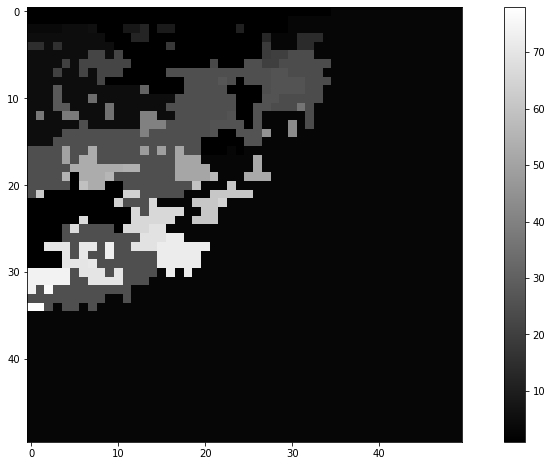

In [50]:
image_r_copy = image_r.copy()
result_intensity_merging = distance_merging_while(image_r_copy,0.05,image_intensity)
image_r_copy = result_intensity_merging[0]
print(image_r_copy)
ip.show_image(image_r_copy, 15, 8)

In [51]:
image_r_copy = region_merging_size(image_intensity,image_r_copy, result_intensity_merging[1],result_intensity_merging[2], 1000)
ip.show_image(image_r_copy,15,8)

1
9
1
0
1
23
1
28
1
19
1


IndexError: index 0 is out of bounds for axis 0 with size 0